In [1]:
from py_wgpu_fdm import Simulation
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation


In [2]:
import numpy as np

COPPER_DENSITY = 8960.0  # kg / m^3

def quat_from_frame(tangent, normal, binormal):
    """
    Convert orthonormal frame to quaternion (x, y, z, w).
    Matches WGSL logic where d3 = tangent.
    """
    # R stack order: normal=d1, binormal=d2, tangent=d3
    R = np.stack([normal, binormal, tangent], axis=1)
    
    q = np.empty(4)
    tr = np.trace(R)
    if tr > 0:
        S = np.sqrt(tr + 1.0) * 2
        q[3] = 0.25 * S
        q[0] = (R[2,1] - R[1,2]) / S
        q[1] = (R[0,2] - R[2,0]) / S
        q[2] = (R[1,0] - R[0,1]) / S
    else:
        if R[0,0] > R[1,1] and R[0,0] > R[2,2]:
            S = np.sqrt(1.0 + R[0,0] - R[1,1] - R[2,2]) * 2
            q[3] = (R[2,1] - R[1,2]) / S
            q[0] = 0.25 * S
            q[1] = (R[0,1] + R[1,0]) / S
            q[2] = (R[0,2] + R[2,0]) / S
        elif R[1,1] > R[2,2]:
            S = np.sqrt(1.0 + R[1,1] - R[0,0] - R[2,2]) * 2
            q[3] = (R[0,2] - R[2,0]) / S
            q[0] = (R[0,1] + R[1,0]) / S
            q[1] = 0.25 * S
            q[2] = (R[1,2] + R[2,1]) / S
        else:
            S = np.sqrt(1.0 + R[2,2] - R[0,0] - R[1,1]) * 2
            q[3] = (R[1,0] - R[0,1]) / S
            q[0] = (R[0,2] + R[2,0]) / S
            q[1] = (R[1,2] + R[2,1]) / S
            q[2] = 0.25 * S
    return (q / np.linalg.norm(q)).astype(np.float32)

def generate_helical_spring_frenet(
    spring_height: float,
    windings: int,
    helix_diameter: float = 0.015,
    wire_diameter: float = 0.01,
    nodes_per_winding: int = 16, # Higher density recommended for stability
):
    R_helix = 0.5 * helix_diameter
    r_wire = 0.5 * wire_diameter
    node_count = windings * nodes_per_winding + 1
    
    # Generate helical geometry
    theta = np.linspace(0.0, 2.0 * np.pi * windings, node_count)
    h = np.linspace(0.0, spring_height, node_count)
    positions = np.stack([
        h, 
        R_helix * np.cos(theta), 
        R_helix * np.sin(theta)
    ], axis=1).astype(np.float32)

    # 1. Geometry and dx
    diffs = positions[1:] - positions[:-1]
    dx = np.linalg.norm(diffs[0])
    tangents = diffs / np.linalg.norm(diffs, axis=1, keepdims=True)

    # 2. Physics: Mass and Inertia
    area = np.pi * (r_wire**2)
    mass = float(COPPER_DENSITY * area * dx)
    I1 = (np.pi * r_wire**4) / 4.0 # Bending
    I3 = (np.pi * r_wire**4) / 2.0 # Torsion
    inertia = (COPPER_DENSITY * np.array([I1, I1, I3])).astype(np.float32)

    # 3. Build Nodes list
    nodes = [(pos, np.zeros(3, dtype=np.float32)) for pos in positions]
    
    # 4. Build Edges (Parallel Transport to minimize artificial twist)
    edges = []
    # Initial normal: avoid singularity with tangent
    t0 = tangents[0]
    up = np.array([0, 1, 0]) if abs(t0[0]) < 0.9 else np.array([0, 0, 1])
    n0 = np.cross(t0, up)
    n0 /= np.linalg.norm(n0)
    
    curr_n = n0
    for i in range(node_count - 1):
        t = tangents[i]
        b = np.cross(t, curr_n)
        b /= np.linalg.norm(b)
        n = np.cross(b, t)
        
        q = quat_from_frame(t, n, b)
        edges.append((q, np.zeros(3, dtype=np.float32)))
        curr_n = n # Transport normal to next segment

    # 5. Add Ghost Edge
    # Copy orientation of last segment to ensure zero curvature at tail
    ghost_q = edges[-1][0]
    edges.append((ghost_q, np.zeros(3, dtype=np.float32)))

    return nodes, edges, float(dx), mass, inertia

def add_center_z_velocity(nodes, num_nodes=20, magnitude=0.1, std=0.01):
    N = len(nodes)
    center_idx = N // 2
    half_span = num_nodes // 2
    start = max(center_idx - half_span, 0)
    end = min(center_idx + half_span, N)

    vz = magnitude + np.random.normal(loc=0.0, scale=std, size=(end - start,))
    vz = vz.astype(np.float32)

    for i, idx in enumerate(range(start, end)):
        pos, vel = nodes[idx]
        # Adding to the Z component (perpendicular to spring axis X)
        new_vel = np.array([vel[0], vel[1], vel[2] + vz[i]], dtype=np.float32)
        nodes[idx] = (pos, new_vel)

    return nodes
    

In [15]:
nodes, edges, dx, mass, inertia = generate_helical_spring_frenet(
    spring_height= 0.2,   # 5 cm
    windings=50,
    helix_diameter=0.015,
    wire_diameter=0.0010,
    nodes_per_winding=12
)

nodes = add_center_z_velocity(nodes, magnitude=10)

In [16]:
nodes[200]

(array([ 0.06666667, -0.00375   , -0.00649519], dtype=float32),
 array([0., 0., 0.], dtype=float32))

In [17]:
import numpy as np
import matplotlib.pyplot as plt


def plot_spring(nodes, edges, show_nodes=True):
    """
    nodes: Vec<[[x,y,z], [vx,vy,vz]]>
    edges: Vec<([qx,qy,qz,qw], [mx,my,mz])>
    """

    positions = np.array([n[0] for n in nodes])

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")

    # Plot edges as a polyline
    ax.plot(
        positions[:, 0],
        positions[:, 1],
        positions[:, 2],
        lw=2,
        color="steelblue",
        label="Rod centerline",
    )

    # Plot nodes
    if show_nodes:
        ax.scatter(
            positions[:, 0],
            positions[:, 1],
            positions[:, 2],
            color="crimson",
            s=15,
            label="Nodes",
        )

    # Axis labels
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")

    ax.set_title("Discretized Helical Spring (Initial Configuration)")
    ax.legend()

    # Equal aspect ratio (important!)
    max_range = (
        np.array([
            positions[:, 0].max() - positions[:, 0].min(),
            positions[:, 1].max() - positions[:, 1].min(),
            positions[:, 2].max() - positions[:, 2].min(),
        ]).max() / 2.0
    )

    mid = positions.mean(axis=0)

    ax.set_xlim(mid[0] - max_range, mid[0] + max_range)
    ax.set_ylim(mid[1] - max_range, mid[1] + max_range)
    ax.set_zlim(mid[2] - max_range, mid[2] + max_range)

    plt.tight_layout()
    plt.show()


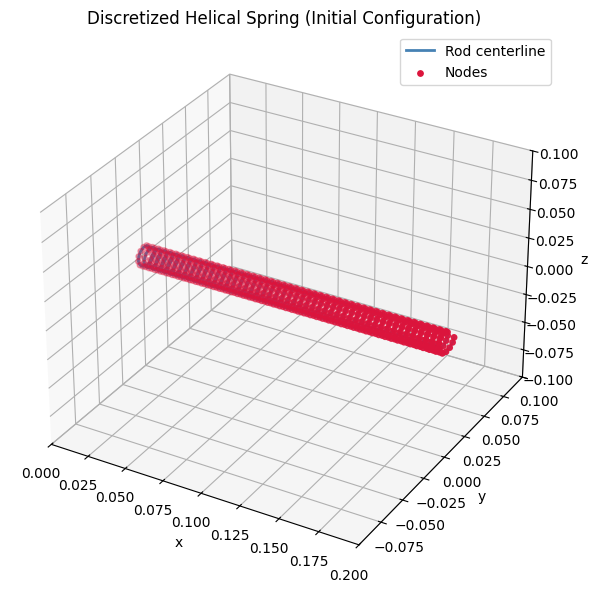

Discrete spring has 601 nodes


In [18]:
plot_spring(nodes, edges)
print(f'Discrete spring has {len(nodes)} nodes')

In [19]:
sim = Simulation(
    nodes=nodes,
    edges=edges,
    oversampling_factor=128,
    chunk_size=128,
    dt=1e-10,
    dx=dx,
    mass=mass,
    stiffness_se = [8.6e6, 3.2e6, 3.2e6],
    stiffness_bt = [4.0, 5.4, 5.4],
    inertia=inertia,
)


In [20]:
sim.initialize(0.0, 1)

Calling init!


In [21]:
frames = list()

for i in range(15):
    sim.compute()
    f = sim.save()
    frames.extend(f)

In [22]:
import numpy as np
import matplotlib.pyplot as plt


def plot_spring_from_positions(positions, show_nodes=True):
    """
    positions: array-like of shape (N, 3)
               each entry is [x, y, z]
    """

    positions = np.asarray(positions)
    assert positions.ndim == 2 and positions.shape[1] == 3

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")

    # Connect nodes
    ax.plot(
        positions[:, 0],
        positions[:, 1],
        positions[:, 2],
        lw=2,
        color="steelblue",
        label="Spring centerline",
    )

    # Optional node markers
    if show_nodes:
        ax.scatter(
            positions[:, 0],
            positions[:, 1],
            positions[:, 2],
            color="crimson",
            s=15,
            label="Nodes",
        )

    # Labels
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.set_title("Spring Configuration")

    # Equal aspect ratio (important!)
    max_range = np.ptp(positions, axis=0).max() / 2.0
    mid = positions.mean(axis=0)

    ax.set_xlim(mid[0] - max_range, mid[0] + max_range)
    ax.set_ylim(mid[1] - max_range, mid[1] + max_range)
    ax.set_zlim(mid[2] - max_range, mid[2] + max_range)

    ax.legend()
    plt.tight_layout()
    plt.show()


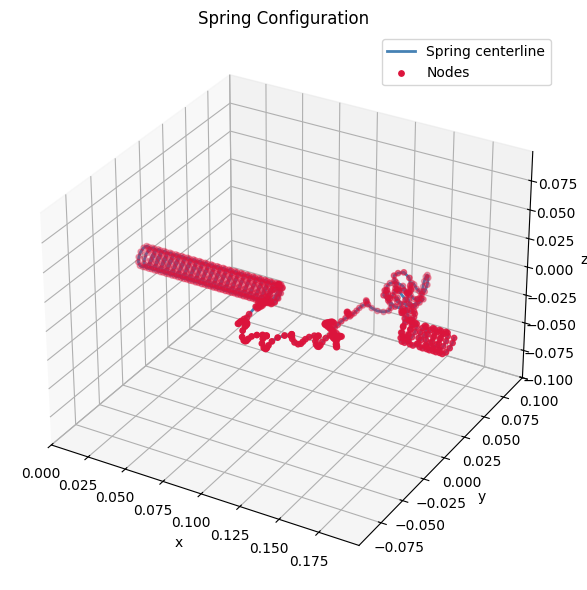

In [27]:
p = [ n[0] for n in frames[1500] ]
plot_spring_from_positions(p)

In [31]:
for f in frames:
    n = f[200]
    print(n[0][1])

-0.0037499999161809683
-0.0037499999161809683
-0.0037499999161809683
-0.0037499999161809683
-0.0037499999161809683
-0.0037499999161809683
-0.0037499999161809683
-0.0037499999161809683
-0.0037499999161809683
-0.0037499999161809683
-0.0037499999161809683
-0.0037499999161809683
-0.0037499999161809683
-0.0037499999161809683
-0.0037499999161809683
-0.0037499999161809683
-0.0037499999161809683
-0.0037499999161809683
-0.0037499999161809683
-0.0037499999161809683
-0.0037499992176890373
-0.0037499992176890373
-0.0037499992176890373
-0.0037499992176890373
-0.0037499992176890373
-0.0037499992176890373
-0.0037499992176890373
-0.0037499992176890373
-0.0037499992176890373
-0.0037499992176890373
-0.0037499992176890373
-0.0037499992176890373
-0.0037499992176890373
-0.0037499992176890373
-0.0037499992176890373
-0.0037499992176890373
-0.0037499992176890373
-0.0037499992176890373
-0.0037499992176890373
-0.0037499992176890373
-0.0037499992176890373
-0.0037499992176890373
-0.0037499992176890373
-0.00374999

In [13]:
p[2]

[0.26856914162635803, -1.3435145616531372, 0.30937308073043823]